Using Colab cache for faster access to the 'wine-quality-dataset' dataset.
Dataset Shape: (1143, 13)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,2
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,3
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,4



=== Decision Tree Performance ===
Accuracy: 87.34 %
              precision    recall  f1-score   support

         Bad       0.90      0.96      0.93       197
        Good       0.58      0.34      0.43        32

    accuracy                           0.87       229
   macro avg       0.74      0.65      0.68       229
weighted avg       0.86      0.87      0.86       229


=== Random Forest Performance ===
Accuracy: 91.7 %
              precision    recall  f1-score   support

         Bad       0.94      0.96      0.95       197
        Good       0.74      0.62      0.68        32

    accuracy                           0.92       229
   macro avg       0.84      0.79      0.82       229
weighted avg       0.91      0.92      0.91       229



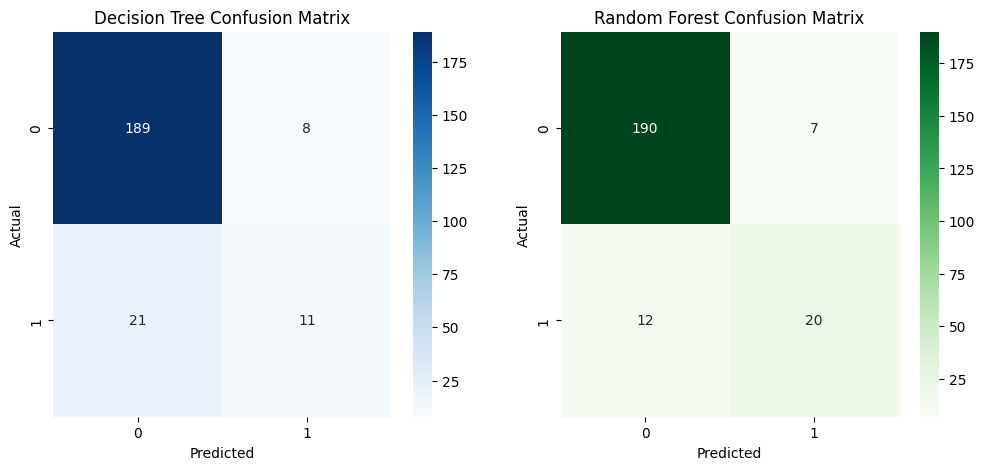

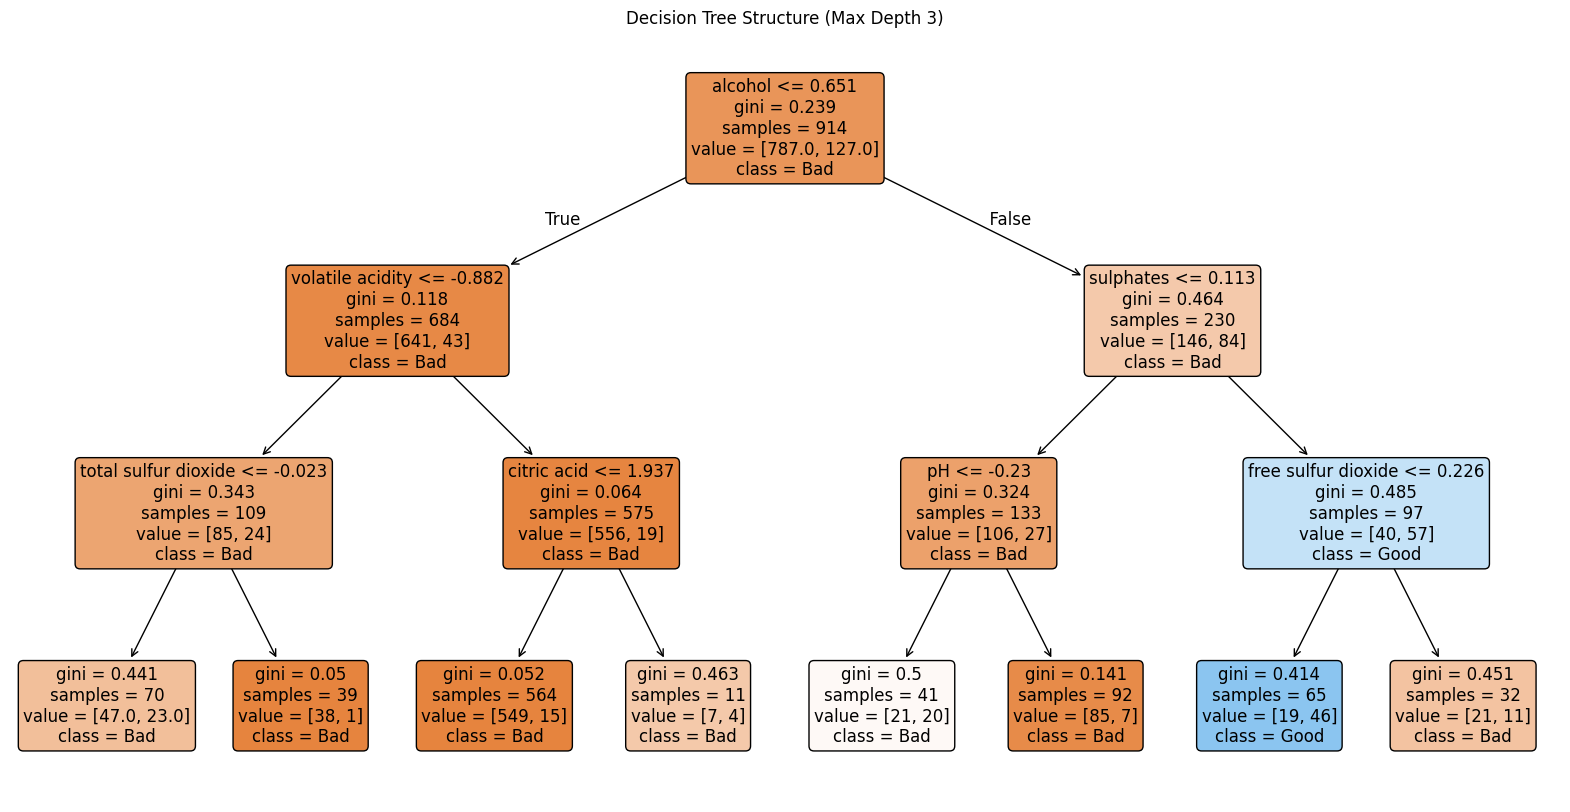

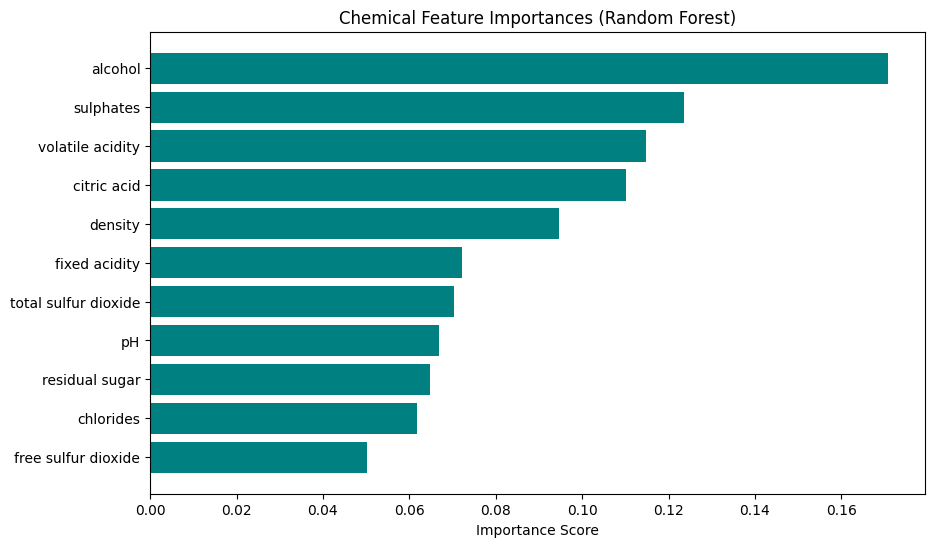

In [1]:
# Install dependency
!pip install kagglehub -q

import kagglehub
from kagglehub import KaggleDatasetAdapter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# -------------------------
# 1. Load Data (Wine Quality Dataset)
# -------------------------
# Download the dataset
path = kagglehub.dataset_download("yasserh/wine-quality-dataset")

# Find the CSV file inside the downloaded folder
csv_file = [f for f in os.listdir(path) if f.endswith('.csv')][0]
df = pd.read_csv(os.path.join(path, csv_file))

print("Dataset Shape:", df.shape)
display(df.head())

# -------------------------
# 2. Preprocessing
# -------------------------
# Convert 'quality' into a binary classification task: "Good" (1) if quality > 6, else "Bad" (0)
# This creates a more distinct boundary for tree-based models to learn.
df['quality_label'] = (df['quality'] > 6).astype(int)

# Drop the original quality column and any identifier columns
X = df.drop(columns=["quality", "quality_label", "Id"], errors='ignore')
y = df["quality_label"]

# Split Data
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Scaling (Optional for Trees, but recommended for consistent workflows)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# -------------------------
# 3. Train Models
# -------------------------
# Decision Tree (Baseline)
# max_depth=3 allows us to easily visualize the decision logic
dt = DecisionTreeClassifier(max_depth=3, random_state=42)
dt.fit(X_train_scaled, y_train)
dt_preds = dt.predict(X_test_scaled)

# Random Forest (Ensemble)
# n_estimators=100 uses Bagging to reduce the variance of individual trees
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42
)
rf.fit(X_train_scaled, y_train)
rf_preds = rf.predict(X_test_scaled)

# -------------------------
# 4. Evaluation
# -------------------------
print("\n=== Decision Tree Performance ===")
print("Accuracy:", round(accuracy_score(y_test, dt_preds) * 100, 2), "%")
print(classification_report(y_test, dt_preds, target_names=["Bad", "Good"]))

print("\n=== Random Forest Performance ===")
print("Accuracy:", round(accuracy_score(y_test, rf_preds) * 100, 2), "%")
print(classification_report(y_test, rf_preds, target_names=["Bad", "Good"]))

# -------------------------
# 5. Visualizations
# -------------------------

# Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(confusion_matrix(y_test, dt_preds),
            annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title("Decision Tree Confusion Matrix")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

sns.heatmap(confusion_matrix(y_test, rf_preds),
            annot=True, fmt="d", cmap="Greens", ax=axes[1])
axes[1].set_title("Random Forest Confusion Matrix")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.show()

# Decision Tree Structure Plot
#
plt.figure(figsize=(20, 10))
plot_tree(
    dt,
    feature_names=X.columns,
    class_names=["Bad", "Good"],
    filled=True,
    fontsize=12,
    rounded=True
)
plt.title("Decision Tree Structure (Max Depth 3)")
plt.show()

# Feature Importance Plot (Random Forest)
#
importances = rf.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10, 6))
plt.barh(X.columns[indices], importances[indices], color='teal')
plt.title("Chemical Feature Importances (Random Forest)")
plt.xlabel("Importance Score")
plt.show()